In [20]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import spacy
import json
import numpy as np
import pandas as pd
import re
import string
import multiprocessing
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction import text
from sklearn.metrics import silhouette_score
import joblib

In [6]:
# import sys
# print(sys.path)

In [5]:
# conda list scikit-learn

In [7]:
# '/home/cpan/miniconda3/envs/myenv/lib/python3.11/site-packages' in sys.path

In [8]:
# conda install scikit-learn

In [9]:
save_json_file_path = '/ghphi/data/phi/clean_test_results/labeled_test_results_3000.json'

In [10]:
with open(save_json_file_path, "r") as f:
    data = json.load(f)

In [11]:
custom_stopwords = ['information', 'patient', 'redacted', 'REDACTED', 'redactedredacted', "fax", "page", 'patient', 'mg', 'clinical', 'cancer', 'diego' 'san', 'null', 'file', 'printed', 'information', 'mg', 'report', 'final']
my_stopwords = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

In [12]:
ner_basic = spacy.load("en_core_web_sm")

In [13]:
def median_page_num_per_folder(data):
    # Create a DataFrame
    df = pd.DataFrame(data)

    # Extract folder names
    df['folder_name'] = df['file_name'].str.split('/').str[0]

    # Group by folder name and calculate the median number of pages per folder
    median_pages_per_folder = df.groupby('folder_name')['file_name'].count().median()

    print("Median number of pages per folder:", median_pages_per_folder)
median_page_num_per_folder(data)

Median number of pages per folder: 2.0


In [14]:
# Function to perform text cleaning using spaCy, filter out digits, and exclude stopwords
def preprocess_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove dates
    text = re.sub(r'\d{1,2}\/\d{1,2}\/\d{4}', '', text)

    # Remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

def clean_text(text_):
    text = preprocess_text(text_)
    doc = ner_basic(text)
    cleaned_text = " ".join(token.lemma_ for token in doc if not (token.is_punct or token.is_digit or token.is_stop or token.lemma_ in my_stopwords))
    return cleaned_text

# combine page content with clean_text and filtering out digits and stopwords
def combine_page_content(data):
    all_pages = []
    for item in data:
        file_name = item['file_name']  # Get the file name
        tests = item['tests']
        page_content = item['page_content'] # page content from one page
        # skip those pages with empty test results
        if len(tests)<1:
            continue
        cleaned_page = clean_text(page_content)
        # store file_name, cleaned_pages to keep track of the pages in cluster 
        all_pages.append((file_name, cleaned_page))
    return all_pages

def get_page_content(pages):
    all_pages = []
    for _, page_content in pages:
        all_pages.append(page_content)
    return all_pages

In [15]:
def custom_tokenizer(text):
    tokens = text.split()  # Split text into tokens
    filtered_tokens = [token for token in tokens if len(token) > 2]  # Exclude tokens with one element
    return filtered_tokens

In [16]:
all_pages_with_filename = combine_page_content(data)
all_page_content = get_page_content(all_pages_with_filename)

In [17]:
all_pages_with_filename[0]

('A0338591/image-029.txt',
 '  Paae       GMT     Pickering   GUARDANT   DOB NOV     Test Number   additional available therapeutic annotation base publicly available detailed relevance Detected Alterations section visit portalguardanthealthcom amail clientservicesguardanthealthcam subject line arnail   additional trial   Relevance Detected Alterations Detailed Fherapy Results References like receive additional guardant client service   optin g UARD NT detailed Guardant Patient Report available online portal TSTPRT r   Pg     ortalquardanthealthcom set account contact Client Gervices')

In [18]:
# tf-idf tokenizer 
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=list(my_stopwords), token_pattern=r'\b[^\d\W]+\b', preprocessor=preprocess_text, use_idf=True)
data_vectorized = vectorizer.fit_transform(all_page_content)

/home/cpan/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
joblib.dump(data_vectorized, 'data_vectorized_hierarchical.pkl')
joblib.dump(vectorizer, 'vectorizer_hiearchical.pkl')

['vectorizer_hiearchical.pkl']

In [22]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [23]:
data_file_names = [item['file_name'] for item in data]

In [30]:
def find_optimal_clusters(data, max_clusters):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        agglomerative = AgglomerativeClustering(n_clusters=k)
        cluster_labels = agglomerative.fit_predict(data.toarray())
        silhouette_scores.append(silhouette_score(data.toarray(), cluster_labels))

    return silhouette_scores

/home/cpan/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/cpan/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/cpan/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/cpan/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/cpan/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/cpan/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/cpan/miniconda3/envs/myenv/lib/python3.11/site

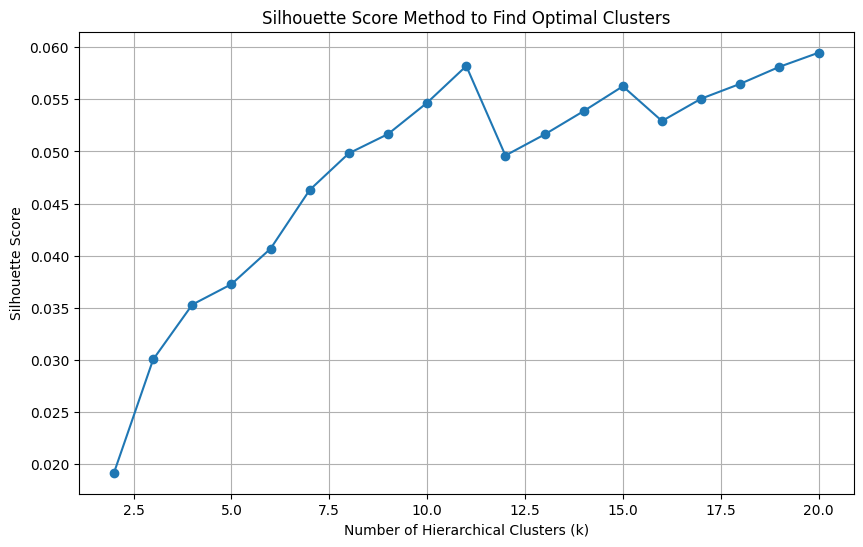

In [31]:
# Maximum number of clusters to try
max_clusters = 20  # Or any other suitable value

# Find the optimal number of clusters using the Silhouette score
silhouette_scores = find_optimal_clusters(data_vectorized, max_clusters)

# Plot the silhouette scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Hierarchical Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method to Find Optimal Clusters')
plt.grid(True)
plt.show()

In [32]:
optimal_clusters = 20

In [33]:
def fit_agglomerative_and_get_top_keywords(data, file_names, num_clusters, num_top_keywords=10):
    page_contents = get_page_content(data)
    # TF-IDF vectorization
    # vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=list(my_stopwords), token_pattern=r'\b[^\d\W]+\b', preprocessor=preprocess_text, use_idf=True)
    # data_vectorized = vectorizer.fit_transform(page_contents)

    # Fit Agglomerative Clustering on the data
    agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
    # agglomerative = joblib.load('/ghdevhome/home/cpan/notebooks/models/best_fitted_agglomerative_model.pkl')
    clusters = agglomerative.fit_predict(data_vectorized.toarray())

    # Extract cluster keywords (similar to your KMeans approach)
    order_centroids = np.argsort(data_vectorized.toarray())[:, ::-1]
    terms = np.array(vectorizer.get_feature_names_out())

    cluster_keywords = {}
    for cluster_idx in range(num_clusters):
        top_keyword_indices = order_centroids[clusters == cluster_idx][:, :num_top_keywords]
        top_keywords = [terms[idx] for idx in top_keyword_indices.ravel()]

        cluster_keywords[cluster_idx] = top_keywords

    # Assign file names to their respective clusters
    cluster_file_names = {i: [] for i in range(num_clusters)}  # Initialize dictionary to store file names for each cluster

    for idx, (file_name, _) in enumerate(data):
        cluster_file_names[clusters[idx]].append(file_name)

    return agglomerative, clusters, cluster_keywords, cluster_file_names

# Fit Agglomerative Clustering and get top keywords while keeping track of file names for each cluster
agglomerative, clusters, cluster_keywords, cluster_file_names = fit_agglomerative_and_get_top_keywords(all_pages_with_filename, data_file_names, optimal_clusters)

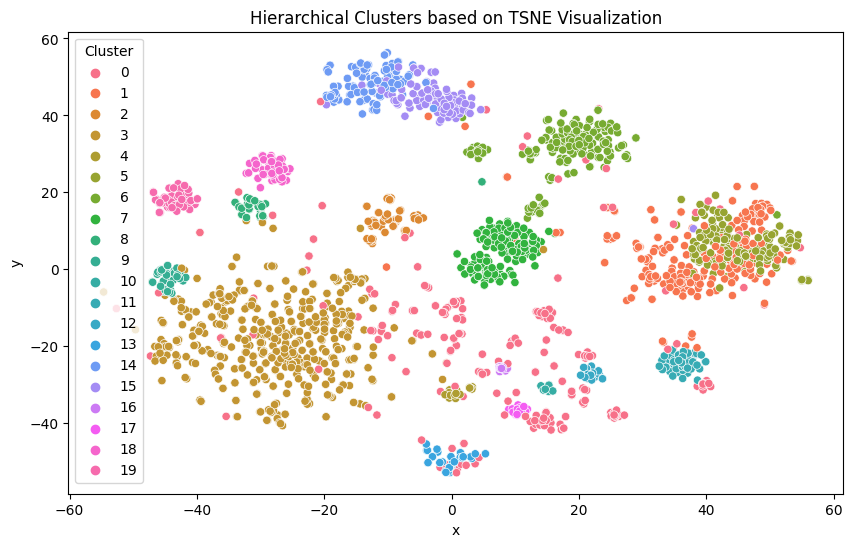

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Fit PCA or t-SNE on the data_vectorized
# For example, using PCA:
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(data_vectorized.toarray())

# using t-SNE:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_data = tsne.fit_transform(data_vectorized.toarray())

# Create a DataFrame with reduced data and cluster labels
cluster_df2 = pd.DataFrame({'x': reduced_data[:, 0], 'y': reduced_data[:, 1], 'cluster': clusters})

# Set up a colormap
cmap = sns.color_palette("husl", n_colors=optimal_clusters)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=cluster_df2, palette=cmap)
plt.title("Hierarchical Clusters based on TSNE Visualization")
plt.legend(title="Cluster")
plt.show()
# cluster 6, 7, 15 seems the most dense 

In [40]:
def create_keyword_dataframe(cluster_keywords, num_top_keywords=10):
    data = []
    for cluster_id, keywords in cluster_keywords.items():
        keywords_list = keywords[:num_top_keywords] + ['N/A'] * (num_top_keywords - len(keywords))
        data.append([cluster_id ] + keywords_list)

    columns = ["Cluster"] + [f"Top Keyword {i+1}" for i in range(num_top_keywords)]
    df = pd.DataFrame(data, columns=columns)
    return df

In [41]:
keywords_df = create_keyword_dataframe(cluster_keywords)

In [42]:
keywords_df

,Cluster,Top Keyword 1,Top Keyword 2,Top Keyword 3,Top Keyword 4,Top Keyword 5,Top Keyword 6,Top Keyword 7,Top Keyword 8,Top Keyword 9,Top Keyword 10
0,0,gene,raport,sequence,type,variants,result,clinically,exon,alteration,laboratory
1,1,Map,Response,Tumor,descendh,Gasconding,definttion,SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSMsses,ennotate,onllne,Pano
2,2,dione,DEBARRY,Atsrations,torre,Tag,jause,Arnps,Bie,ofona,AEST
3,3,paclitaxel,colon,measure,right,pRBC,cystic,ascend,adenopathy,mSUV,pack
4,4,recipiant,authorization,intend,confidentiality,maintain,recipient,prohibit,transmission,www,disclosure
5,5,Tumor,dotinition,dotail,sestion,Synonyrnous,REDACTEDPRTO,cfdna,alfele,tabie,Pickering
6,6,UARD,arnail,Fherapy,additional,Pickering,amail,clientservicesguardanthealthcam,Detected,client,optin
7,7,yes,MAR,Alterations,Biomarkers,Additional,MSHigh,Paniturnurnab,Loudoun,Reston,tharapautic
8,8,NSCLC,mutation,association,study,PDPDL,tumor,resistance,therapy,MEK,approach
9,9,outside,solid,daily,hcl,group,Print,RIVER,twice,instruction,Doxycycline


base on keywords dataframe, the following clusters seem like they belong to test results: 
- cluste0: gene, variant, result
- cluster5: tumor
- cluster7: biomarker
- cluster8: mutation, tumor, approach
- cluster10: cdx, foundationOne
- cluster12: test, germline, diagnostic
- cluster13:myrisk
- cluster14: clinical, study
- cluster18: cancer, mutant
- cluster 19: inhibitor, tumor

In [43]:
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist

In [52]:
# Calculate pairwise distances and closest points between clusters
closest_points, _ = pairwise_distances_argmin_min(agglomerative.children_, agglomerative.children_, metric='euclidean')

# Identify closest cluster pairs
closest_clusters = [(i, closest_points[i]) for i in range(len(closest_points))]

# Calculate pairwise distances between cluster centers
distances = cdist(agglomerative.children_, agglomerative.children_, metric='euclidean')

# Set diagonal elements (distance to itself) to a large value
np.fill_diagonal(distances, np.inf)

# Find indices of the closest cluster pair
row_idx, col_idx = np.unravel_index(np.argmin(distances), distances.shape)

# Get the actual distance
min_distance = distances[row_idx, col_idx]

# Get the cluster indices
closest_cluster_1 = row_idx
closest_cluster_2 = col_idx

print(f"Clusters {closest_cluster_1} and {closest_cluster_2} are closest with a distance of {min_distance:.4f}")

Clusters 0 and 14 are closest with a distance of 1.4142


In [54]:
# choose cluster 4, 8, 15 as the potential clusters for test results based on manual observation 
# choose cluster 0, 14 as the potential cluster for test results based on pairwise evidence 
closest_key_file_names = cluster_file_names[0] + cluster_file_names[5] + cluster_file_names[7] + cluster_file_names[8]+\
cluster_file_names[10]+ cluster_file_names[12] + cluster_file_names[13] + cluster_file_names[14]+ cluster_file_names[18] + cluster_file_names[19]
print(len(closest_key_file_names))

923


In [55]:
# export closest key file names 
# Specify the path for the output text file
path_txt =  '/ghphi/data/phi/page_classification_data/'
output_file_path = 'hierarchical_closest_key_file_names.txt'

# Write the file names to the output text file
with open(path_txt + output_file_path, 'w') as file:
    for file_name in closest_key_file_names:
        file.write(f"{file_name}\n")

print("File names exported to:", output_file_path)

File names exported to: hierarchical_closest_key_file_names.txt


In [51]:
# Calculate Silhouette Score for hiearchical clustering 
hierarchical_silhouette_score = silhouette_score(data_vectorized, clusters)
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette_score:.4f}")

Silhouette Score for Hierarchical Clustering: 0.0595
